In [73]:
#interactive plotting in separate window
%matplotlib qt 
#%matplotlib inline 

QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-gfrances'
failed to get the current screen resources
QXcbConnection: XCB error: 170 (Unknown), sequence: 170, resource id: 90, major code: 146 (Unknown), minor code: 20


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.optimize import curve_fit

In [2]:
#reading data
data_df = pd.read_csv('data/sE76T1p6sub_map_E=minus13-67_q=0-12.txt', comment = "#")

In [3]:
#saving df columns in array
Q_arr = data_df["Q"].to_numpy() 
E_arr = data_df["E"].to_numpy() 
S_arr = data_df["S"].to_numpy() 
S_E_arr = data_df["S_E"].to_numpy()

#delete duplicate values due to grid structure
Q_arr = np.unique(Q_arr)
E_arr = np.unique(E_arr)

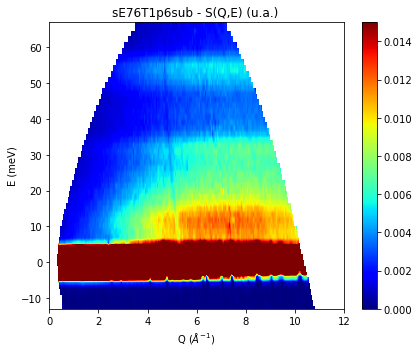

In [4]:
#plotting
x= Q_arr
y= E_arr
z = S_arr
Z = z.reshape(len(x), len(y))
Z = Z.transpose()
Z = np.flipud(Z)

fig =plt.figure(figsize=(6, 5))
plt.imshow(Z, aspect='auto', extent = [0,12,-13,67], vmin=0,vmax = 0.015, cmap='jet')# X, Y, Z,5000,vmin=0,vmax = 0.43, cmap='jet')
plt.colorbar()
plt.xlabel('Q ($\AA^{-1}$)')
plt.ylabel('E (meV)')
plt.title('sE76T1p6sub - S(Q,E) (u.a.) ')
plt.tight_layout()
plt.show()
#fig.savefig("./figures/sE76T1p6sub.png")

In [5]:
from modules.fitQ import fitQdistrib, fit_func

In [6]:
#reading data
mantid_df = pd.read_csv('data/cut_sE76T1p6sub_E_10_dE_4.dat')
mantid_df = mantid_df.dropna()

In [7]:
popt_10, pcov_10, Q_arr_10, S_arr_10, S_err_10, Q_ex_10, S_ex_10, Q_fit_10, res_10, S_err_fit_10 = fitQdistrib(mantid_df, 2.6,9.2, 5.2, 5.85, 7.80, 8.6)#, 6.26, 6.6, 7.6, 8.4)

In [8]:
S_arr2D = S_arr.reshape(len(Q_arr), len(E_arr))
S_arr2D = S_arr2D.transpose()
S_arr2D = np.flipud(S_arr2D)

In [9]:
S_int = []
for E_idx in range(S_arr2D.shape[0]):
    S_sum = 0
    for Q_idx in range(S_arr2D.shape[1]):
        if Q_arr[Q_idx]>6.2 and Q_arr[Q_idx]<7.8 :
            S_sum += S_arr2D[E_idx][Q_idx]
    S_int.append(S_sum)  
S_int = np.flip(S_int)

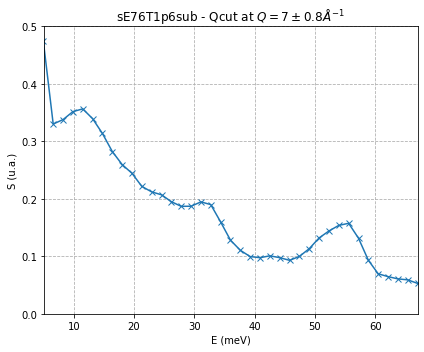

In [10]:
fig =plt.figure(figsize=(6, 5))
plt.grid(linestyle='--')
plt.title('sE76T1p6sub - Qcut at $Q = 7 \pm 0.8 \AA ^{-1}$')  
plt.ylabel('S (u.a.)')
plt.xlabel('E (meV)')
plt.plot(E_arr, S_int, marker = 'x')
plt.xlim([5.1,67])
plt.ylim([0,0.5])
plt.tight_layout()
plt.show()
#fig.savefig("./figures/sE76T1o6sub_Qcut.png")

In [11]:
minimum = abs(Q_arr-7).min()
idx_7 = np.where(abs(Q_arr-7) == minimum)[0][0]

S_7 = []
for E_idx in range(S_arr2D.shape[0]):
    S_7.append(S_arr2D[E_idx][idx_7])
S_7 = np.flip(S_7)

In [12]:
ratio = []
for i in range(len(S_7)):
    if E_arr[i] < 66 and E_arr[i]>6.5 :
        if not (pd.isna(S_int[i]) or pd.isna(S_7[i])):
            ratio.append(S_int[i]/S_7[i])
ratio = np.array(ratio)
print(ratio.mean(), ratio.std())

30.186483349781458 1.7992396674128557


In [13]:
scaling_factors = fit_func(Q_arr, *popt_10)
minimum = abs(Q_arr-7).min()
idx = np.where(abs(Q_arr-7) == minimum)[0][0]

scaling_factors /= scaling_factors[idx]

In [14]:
from scipy import interpolate

def S_splined(E, E_arr, S_arr):
    tck = interpolate.splrep(E_arr, S_arr)
    return float(interpolate.splev(E, tck))

In [15]:
def intensity(Q, S, Q_arr, E_arr, scaling_factors):
    idx_Q = np.where(Q_arr == Q)[0][0]
    intens =  S*scaling_factors[idx_Q]
    return intens

In [16]:
S_mask = []

E_lim = []
S_int_lim = []
for E, S in zip(E_arr, S_int):
    if  (E>6.5 and E<66):
        if not (pd.isna(E) or pd.isna(S)):
            E_lim.append(E)
            S_int_lim.append(S)
        
E_lim = np.array(E_lim)
S_int_lim = np.array(S_int_lim)

        
for Q in Q_arr:
    for E in E_arr:
        if  (E>6.5 and E<66):
            S = S_splined(E, E_lim, S_int_lim)
            S_mask.append(intensity(Q, S, Q_arr, E_lim, scaling_factors))
        else :
            S_mask.append(0)

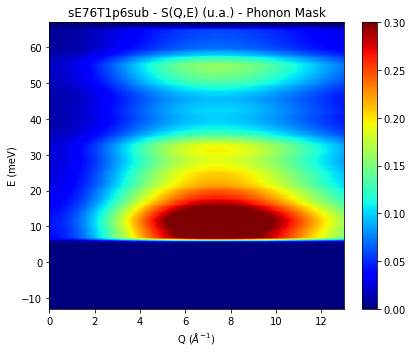

In [19]:
x= Q_arr
y= E_arr
z = np.array(S_mask)
X, Y = np.meshgrid(x, y)
Z = z.reshape(len(x), len(y))
Z = Z.transpose()
Z = np.flipud(Z)
#x = x.transpose()
fig =plt.figure(figsize=(6, 5))
plt.imshow(Z, aspect='auto', extent = [min(x),max(x),min(y),max(y)], vmin=0,vmax = 0.30, cmap='jet')
#plt.contour(X, Y, Z,1000,vmin=0,vmax=0.84,cmap='jet')
plt.colorbar()
plt.xlabel('Q ($\AA^{-1}$)')
plt.ylabel('E (meV)')
plt.title('sE76T1p6sub - S(Q,E) (u.a.) - Phonon Mask')
plt.tight_layout()
plt.show()
fig.savefig("./figures/sE76T1p6sub_mask10.png")

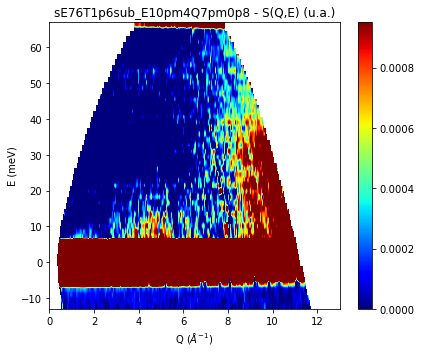

In [17]:
S_mask = np.array(S_mask)
S_arr1 = S_arr-S_mask/ratio.mean()

x= Q_arr
y= E_arr
z = S_arr1
X, Y = np.meshgrid(x, y)
Z = z.reshape(len(x), len(y))
Z = Z.transpose()
Z = np.flipud(Z)
fig =plt.figure(figsize=(6, 5))
plt.imshow(Z, aspect='auto', extent = [0,13,-13,67], vmin=0,vmax = 0.00095, cmap='jet')# X, Y, Z,5000,vmin=0,vmax = 0.43, cmap='jet')
plt.colorbar()
plt.xlabel('Q ($\AA^{-1}$)')
plt.ylabel('E (meV)')
plt.title('sE76T1p6sub_E10pm4Q7pm0p8 - S(Q,E) (u.a.)')
plt.tight_layout()
plt.show()
fig.savefig('./figures/sub_sE76T1p6sub10.png')

In [41]:
y = np.zeros(len(Q_arr))
x = np.zeros(len(E_arr))

In [65]:
E_lim = []
S_lim = []
x = []
for E, S in zip(E_arr,S_int):
    if(E >5 and E<67 ):
        E_lim.append(E)
        S_lim.append(S)
    else:
        E_lim.append(E)
        S_lim.append(0)
    x.append(7)
        

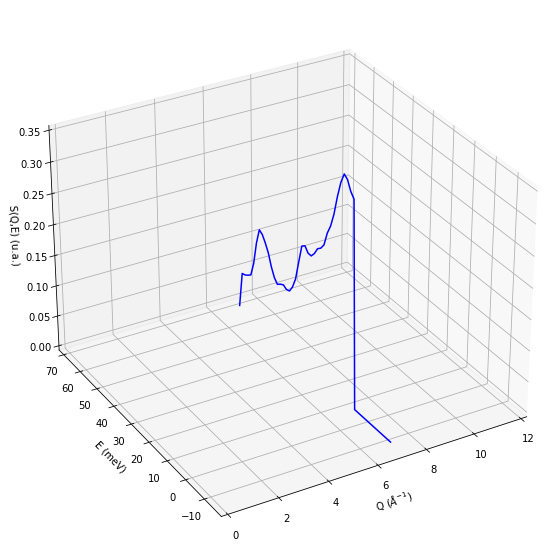

In [86]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection="3d")



ax.plot3D(x, E_lim, S_lim, 'blue')
ax.azim = -120
ax.dist = 10
ax.elev = 30
ax.set_xlim(0,12)
ax.set_zlim(0,0.35)
ax.set_xlabel("Q ($\AA^{-1})$"); ax.set_ylabel("E (meV)"); ax.set_zlabel("S(Q,E) (u.a.)")

plt.show()
fig.savefig('./figures/phmask1.png')

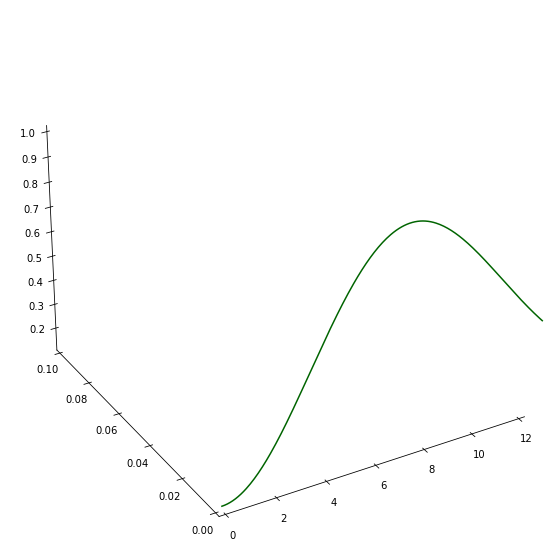

In [87]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection="3d")
#ax.set_axis_off()
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

y = np.array(y)
ax.plot3D(Q_arr, y, scaling_factors, 'darkgreen')
ax.azim = -120
ax.dist = 10
ax.elev = 30
ax.set_xlim(0,12)
ax.set_ylim(0,0.1)
#ax.set_xlabel("Q ($\AA^{-1})$"); ax.set_ylabel("E (meV)"); ax.set_zlabel("S(Q,E) (u.a.)")
fig.savefig('./figures/phmask2.png')
plt.show()

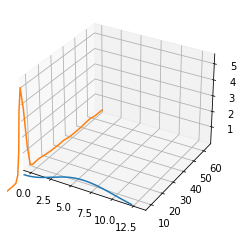

In [45]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(xs= Q_arr, ys = y, zs = scaling_factors, zdir='z')
ax.plot(xs= x, ys = E_arr, zs = S_int, zdir='z')
ax.set_ylim(6.5,66)
plt.show()

#### Q and E cuts on subtracted map

In [26]:
S_arr2D = S_mask.reshape(len(Q_arr), len(E_arr))
S_arr2D = S_arr2D.transpose()
S_arr2D = np.flipud(S_arr2D)

In [27]:
S_Q7_int = []
for E_idx in range(S_arr2D.shape[0]):
    S_sum = 0
    for Q_idx in range(S_arr2D.shape[1]):
        if Q_arr[Q_idx]>6.2 and Q_arr[Q_idx]<7.8 :
            S_sum += S_arr2D[E_idx][Q_idx]
    S_Q7_int.append(S_sum)  
S_Q7_int = np.flip(S_Q7_int)

In [28]:
S_Q4_int = []
for E_idx in range(S_arr2D.shape[0]):
    S_sum = 0
    for Q_idx in range(S_arr2D.shape[1]):
        if Q_arr[Q_idx]>3.2 and Q_arr[Q_idx]<4.8 :
            S_sum += S_arr2D[E_idx][Q_idx]
    S_Q4_int.append(S_sum)  
S_Q4_int = np.flip(S_Q4_int)

In [29]:
S_arr2D = S_arr.reshape(len(Q_arr), len(E_arr))
S_arr2D = S_arr2D.transpose()
S_arr2D = np.flipud(S_arr2D)

In [30]:
S_int4 = []
for E_idx in range(S_arr2D.shape[0]):
    S_sum = 0
    for Q_idx in range(S_arr2D.shape[1]):
        if Q_arr[Q_idx]>3.2 and Q_arr[Q_idx]<4.8 :
            S_sum += S_arr2D[E_idx][Q_idx]
    S_int4.append(S_sum)  
S_int4 = np.flip(S_int4)

In [33]:
ratio1 = []
for i in range(len(S_int)):
    if E_arr[i] < 60 and E_arr[i]>10 :
        if not (pd.isna(S_int[i]) or pd.isna(S_Q7_int[i])):
            ratio1.append(S_Q7_int[i]/S_int[i])
ratio1 = np.array(ratio1)
print(ratio1.mean(), ratio1.std())

29.767827689632448 4.766465574234764e-15


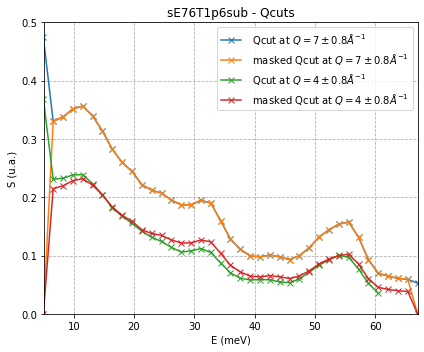

In [37]:
fig =plt.figure(figsize=(6, 5))
plt.grid(linestyle='--')
plt.title('sE76T1p6sub - Qcuts')  
plt.ylabel('S (u.a.)')
plt.xlabel('E (meV)')
plt.plot(E_arr, S_int, marker = 'x', label = " Qcut at $Q = 7 \pm 0.8 \AA ^{-1}$")
plt.plot(E_arr, np.array(S_Q7_int)/ratio1.mean(), marker = 'x', label = " masked Qcut at $Q = 7 \pm 0.8 \AA ^{-1}$")
plt.plot(E_arr, S_int4, marker = 'x', label = " Qcut at $Q = 4 \pm 0.8 \AA ^{-1}$")
plt.plot(E_arr,  np.array(S_Q4_int)/ratio1.mean(), marker = 'x', label = " masked Qcut at $Q = 4 \pm 0.8 \AA ^{-1}$")
plt.xlim([5.1,67])
plt.ylim([0,0.5])
plt.tight_layout()
plt.legend()
plt.show()
fig.savefig("./figures/sE76T1o6sub_Qcuts.png")

In [26]:
S_arr2D = S_arr1.reshape(len(Q_arr), len(E_arr))
S_arr2D = S_arr2D.transpose()
S_arr2D = np.flipud(S_arr2D)

In [27]:
S_E_int = []
for E_idx in range(S_arr2D.shape[0]):
    S_sum = 0
    for Q_idx in range(S_arr2D.shape[1]):
        if Q_arr[Q_idx]>3.2 and Q_arr[Q_idx]<4.8 :
            S_sum += S_arr2D[E_idx][Q_idx]
    S_E_int.append(S_sum)  
S_E_int = np.flip(S_E_int)

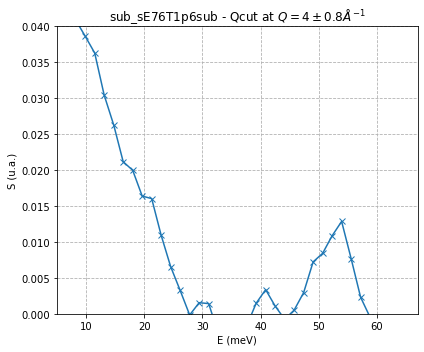

In [37]:
fig =plt.figure(figsize=(6, 5))
plt.grid(linestyle='--')
plt.title('sub_sE76T1p6sub - Qcut at $Q = 4 \pm 0.8 \AA ^{-1}$')  
plt.ylabel('S (u.a.)')
plt.xlabel('E (meV)')
plt.plot(E_arr, S_E_int, marker = 'x')
plt.xlim([5,67])
plt.ylim([0,0.04])
plt.tight_layout()
plt.show()
fig.savefig("./figures/sub_SE76T1p6sub_Qcut.png")

In [33]:
S_arr2D_1 = np.rot90(S_arr2D, axes=(1, 0))
S_arr2D_1.shape

(246, 50)

In [34]:
S_Q_int = []
for Q_idx in range(S_arr2D_1.shape[0]):
    S_sum = 0
    for E_idx in range(S_arr2D_1.shape[1]):
        if E_arr[E_idx]>49 and E_arr[E_idx]<59 :
            S_sum += S_arr2D_1[Q_idx][E_idx]
    S_Q_int.append(S_sum)  
#S_Q_int = np.flip(S_Q_int)

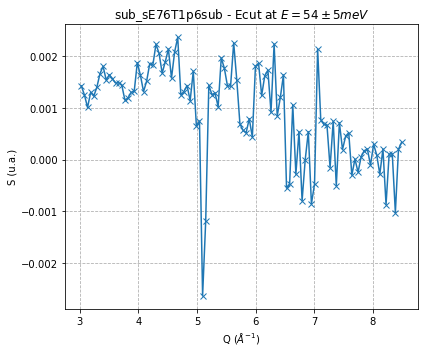

In [38]:
fig =plt.figure(figsize=(6, 5))
plt.grid(linestyle='--')
plt.title('sub_sE76T1p6sub - Ecut at $E = 54 \pm 5 meV$')  
plt.ylabel('S (u.a.)')
plt.xlabel('Q ($\AA ^{-1}$)')
plt.plot(Q_arr, S_Q_int, marker = 'x')
#plt.xlim([5,67])
#plt.ylim([0,0.9])
plt.tight_layout()
plt.show()
fig.savefig("./figures/sub_SE76T1p6sub_Ecut.png")